# Post process for evaluation results

## AUCS results

In [2]:
import glob
import os
import re

import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import numpy as np
import pandas as pd
import seaborn as sns

import joypy
from scipy import stats

plt.rc('font', family='serif')

In [3]:
tick_size = 28
label_size = 20

color_s = sns.color_palette("colorblind")
name_method_dict = {
    "gradshap": {"name": "GradientSHAP", "color": color_s[0], "linestyle": "-o"},
    "integrated_gradients": {
        "name": "Integrated Gradients",
        "color": color_s[1],
        "linestyle": "--o",
    },
    "shapleyvalue": {
        "name": "Shapley Value Sampling",
        "color": color_s[2],
        "linestyle": "-.o",
    },
    "deeplift": {"name": "DeepLIFT", "color": color_s[3], "linestyle": ":o"},
    "deepliftshap": {
        "name": "DeepSHAP",
        "color": color_s[4],
        "linestyle": ":o",
    },
    # "saliency": {"name": "Saliency", "color": color_s[4], "linestyle": "-o"},
    "kernelshap": {
        "name": "KernelSHAP",
        "color": color_s[5],
        "linestyle": "--o",
    },
    "shapley_sampling": {
        "name": "Shapley Value Sampling",
        "color": color_s[7],
        "linestyle": "-.o",
    },
}

In [11]:
def plot_DeltaS_results(save_results):
    """
    Function to create plot summarising the results of the analysis for the different interpretability methods
    Parameters
    ----------
    save_results: str
        path to the folder where the results are stored

    Returns
    -------
    None
    """
    tick_size = 28
    label_size = 28
    path_summary = glob.glob(os.path.join(save_results, "summary_relevance_*.csv"))

    df_summary_metric = pd.read_csv(
        os.path.join(save_results, "metrics_methods.csv"),
        index_col=0,
    )

    results_all = {}
    for path in path_summary:
        df_results = pd.read_csv(path, index_col=0)
        name_file = os.path.split(path)[-1]

        method = re.search("summary_relevance_(.+)\.csv", name_file).group(1)
        results_all[method] = df_results

    if "lime__top" in results_all.keys():
        del results_all["lime__top"]
    if "lime__bottom" in results_all.keys():
        del results_all["lime__bottom"]
    max_nr = 0
    max_metric_score = 0
    for key, val in results_all.items():
        if max((val["metric_score"])) > max_metric_score:
            max_metric_score = max((val["metric_score"]))
        if max((val["mean_ratio_pts_removed"])) > max_nr:
            max_nr = max((val["mean_ratio_pts_removed"]))
            method_max_nr = key

    methop_top_aucse = df_summary_metric["AUCSE_top"].idxmax()
    methop_top_f = df_summary_metric["F_score"].idxmax()

    fig, axs = plt.subplots(
        nrows=2,
        ncols=3,
        figsize=(20, 10),
        sharey=True,
        sharex=True,
        gridspec_kw={"hspace": 0.15, "wspace": 0.15},
    )

    # Defining custom 'xlim' and 'ylim' values.
    custom_xlim = (0, min(round(max_nr * 1.05, 1), 1))
    custom_ylim = (0, min(round(max_metric_score * 1.05, 1), 1))

    loc = plticker.MultipleLocator(
        base=0.2
    )  # this locator puts ticks at regular intervals

    count_ax = 0
    final_keys = [
        'integrated_gradients__bottom', 
        'integrated_gradients__top', 
        'deeplift__bottom', 
        'deeplift__top', 
        'deepliftshap__bottom', 
        'deepliftshap__top', 
        'gradshap__bottom', 
        'gradshap__top', 
        'kernelshap__bottom', 
        'kernelshap__top', 
        'shapleyvalue__bottom', 
        'shapleyvalue__top'
                  ]
    # for idx, key in enumerate(sorted(results_all.keys())):
    for idx, key in enumerate(final_keys):
        split_key = key.split("__")
        method = split_key[0]
        mask = split_key[1]
        if mask == "top":
            if method in name_method_dict.keys():
                name_method = name_method_dict[method]["name"]
                color_method = name_method_dict[method]["color"]
                # linestyle_method = name_method_dict[key]["linestyle"]
                linestyle_mask = "-o"
                markersize_s = 7
            else:
                name_method = key

            df_tmp = results_all[key]
            df_tmp = df_tmp.sort_index()
            ax = axs.ravel()[count_ax]
            ax.set_ylim([0, 1])
            tmp = ax.plot(
                df_tmp.loc[:, "mean_ratio_pts_removed"],
                df_tmp.loc[:, "metric_score"],
                "X-",
                # linestyle_mask,
                markersize=markersize_s,
                color=color_method,
                # label=f"{name_method}",
            )
            df_tmp_bottom = results_all[method + "__bottom"]
            df_tmp_bottom = df_tmp_bottom.sort_index()
            tmp = ax.plot(
                df_tmp_bottom.loc[:, "mean_ratio_pts_removed"],
                df_tmp_bottom.loc[:, "metric_score"],
                linestyle_mask,
                markersize=markersize_s,
                color=color_method,
                # label=f"{name_method}",
            )
            tmp = ax.plot(
                results_all[method_max_nr]
                .sort_index()
                .loc[:, "mean_ratio_pts_removed"],
                results_all[method_max_nr].sort_index().loc[:, "metric_score_random"],
                "-^",
                markersize=markersize_s,
                color="black",
                # label="Random",
            )

            ax.fill_between(
                np.insert(df_tmp_bottom.loc[:, "mean_ratio_pts_removed"].values, 0, 0),
                np.insert(df_tmp.loc[:, "metric_score"].values, 0, 0),
                np.insert(df_tmp_bottom.loc[:, "metric_score"].values, 0, 0),
                alpha=0.5,
                color=color_method,
            )
            count_ax += 1
            aucse_tmp = df_summary_metric.loc[method, "AUCSE_top"]
            f1_tmp = df_summary_metric.loc[method, "F_score"]
            if method == methop_top_aucse:
                weight_aucse = "bold"
                color_aucse = "g"
            else:
                weight_aucse = None
                color_aucse = "black"

            if method == methop_top_f:
                weight_f = "bold"
                color_f = "g"
            else:
                weight_f = None
                color_f = "black"

            if (custom_ylim[1] - df_tmp.loc[:, "metric_score"].max()) < 0.2:
                y_loc_1 = 0.45
                y_loc_2 = 0.3
            else:
                y_loc_1 = 0.8
                y_loc_2 = 0.65

            t = ax.text(
                0.97,
                0.2,
                "$AUC\\tilde{S}_{top}$" + f" = {aucse_tmp :.2f}",
                ha="right",
                va="bottom",
                rotation=0,
                size=18,
                weight=weight_aucse,
                color=color_aucse,
                bbox=dict(boxstyle="round,pad=0.3", fc="white", ec=color_aucse, lw=2),
                transform=ax.transAxes,
            )
            t = ax.text(
                0.97,
                0.05,
                "$F1\\tilde{S}$" + f" = {f1_tmp :.2f}",
                ha="right",
                va="bottom",
                rotation=0,
                size=18,
                weight=weight_f,
                color=color_f,
                bbox=dict(boxstyle="round,pad=0.3", fc="white", ec=color_f, lw=2),
                transform=ax.transAxes,
            )

            ax.grid(True)
            if count_ax in [1, 4]:
                ax.set_ylabel("$\\tilde{S}$", fontsize=label_size)
            if count_ax in [4, 5, 6]:
                ax.set_xlabel("$\\tilde{N}$", fontsize=label_size)

            ax.set_title(f"{name_method}", fontsize=label_size)
            ax.xaxis.set_tick_params(labelsize=tick_size)
            ax.yaxis.set_tick_params(labelsize=tick_size)
            ax.tick_params(axis="x", pad=10)

    fig_path = os.path.join(save_results, "visualization_results")
    if not os.path.exists(fig_path):
        os.makedirs(fig_path)
    plt.setp(axs, xlim=custom_xlim, ylim=custom_ylim)
    # Setting the values for all axes.
    # plt.tight_layout()
    plt.savefig(os.path.join(fig_path, "DeltaS_normalised_mean.png"), dpi=200, bbox_inches='tight')
    # plt.close()

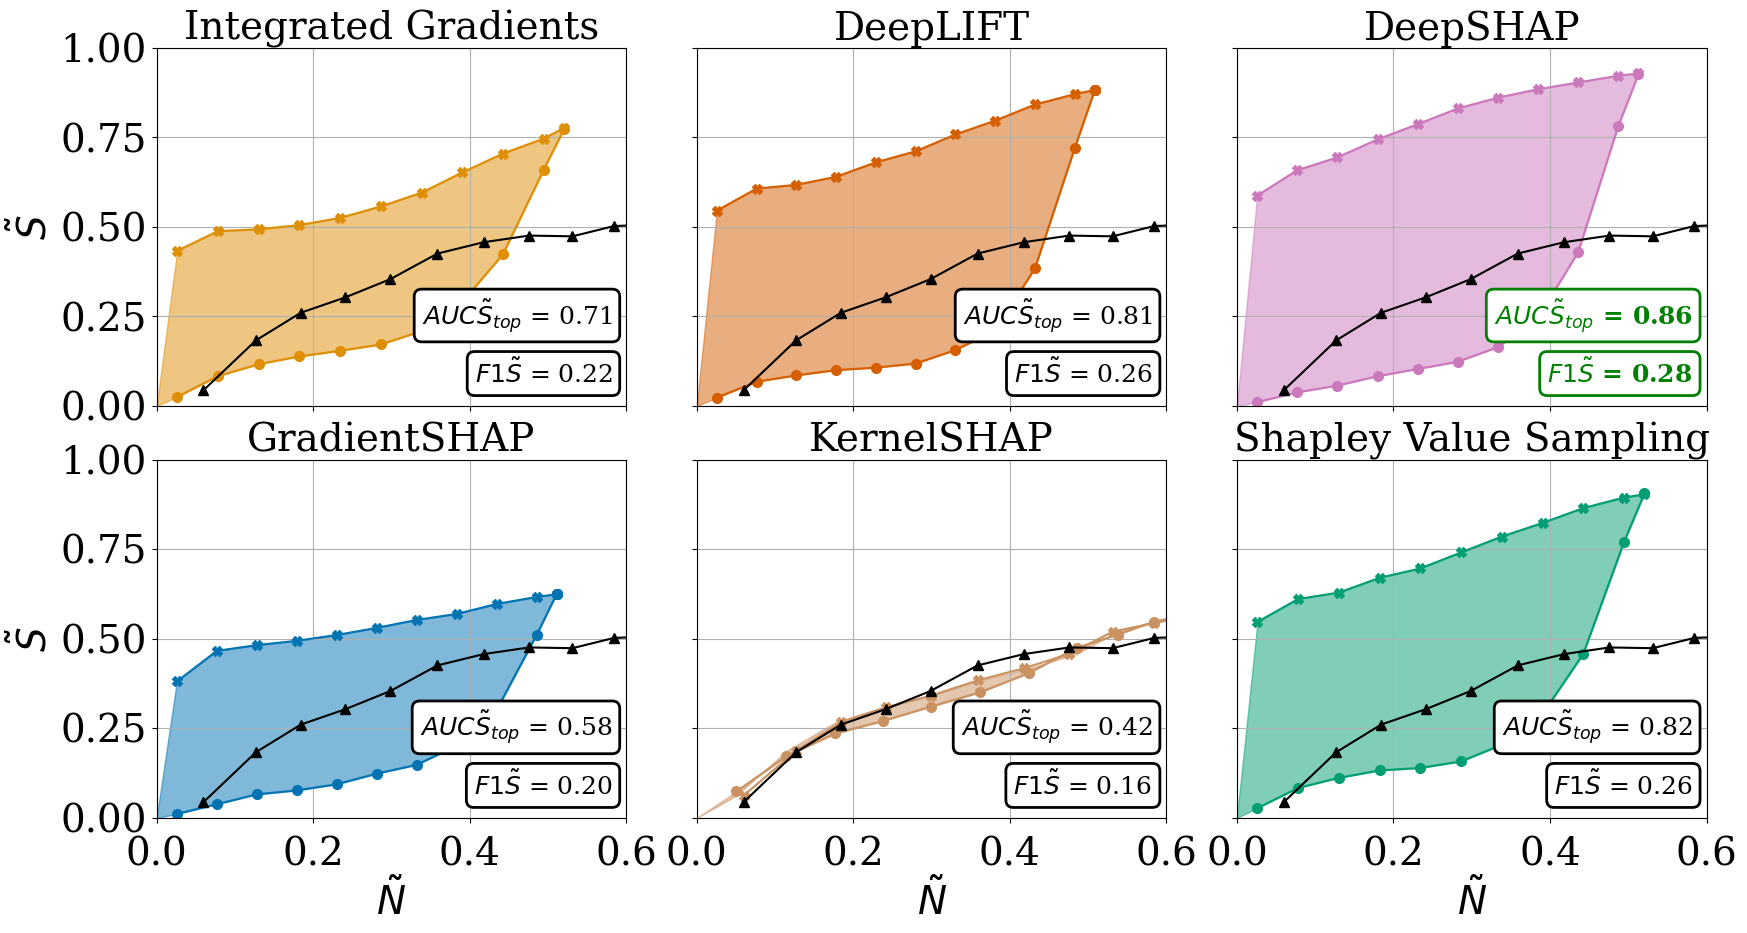

In [12]:
plot_DeltaS_results("interpretability_results/")

## ridge-line plots

In [13]:
all_qfeatures = np.arange(0.05, 1.05, 0.10)
all_qfeatures = np.round(all_qfeatures, 2).tolist()
all_qfeatures

[0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95]

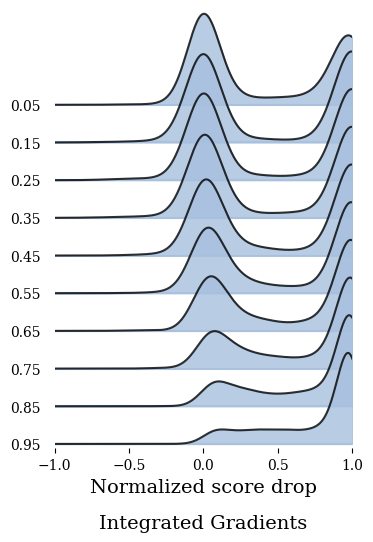

In [27]:

required_columns = [
    "metric_score",
]
methods = [
    'integrated_gradients',
    'deeplift',
    'deepliftshap',
    'gradshap',
    'kernelshap',
    'shapleyvalue'
]


df_reaults_all = pd.DataFrame(columns=['corruption', 'syn_10percent'])
skewness = []
kurtosis = []

for k in all_qfeatures:
    results_path = f"interpretability_results/results_k_feature"
    df_tmp = pd.read_csv(
        # os.path.join(results_path, f"interpretability_shapleyvalue__{k}/results_interp__bottom.csv"),
        os.path.join(results_path, f"interpretability_integrated_gradients__{k}/results_interp__top.csv"),
        index_col=0
    )

    tmp = df_tmp[required_columns].copy().reset_index(drop=True).rename(columns={'metric_score': 'syn_10percent'})
    skewness.append(stats.skew(tmp, bias=True))
    kurtosis.append(stats.kurtosis(tmp, bias=True))

    df_tmp = tmp
    df_tmp['corruption'] = k
    df_reaults_all = pd.concat([df_reaults_all, df_tmp], axis=0, ignore_index=True)

fig, axes = joypy.joyplot(df_reaults_all, column='syn_10percent', by='corruption',
                        fill=True, alpha=.8, legend=False, ylim='own', color='#A7C0DE', kind="kde", x_range=[-1.00001, 1.00001],
                        figsize=(4, 5))
plt.xlabel("Normalized score drop", fontsize=14)
plt.title("Integrated Gradients", fontsize=14, ha='center', x=0.5, y=-0.2)
plt.savefig(os.path.join("interpretability_results/visualization_results", "Ridge_line_ig.png"), dpi=200, bbox_inches='tight')

## AUC skewness

In [14]:
required_columns = [
    "metric_score",
]
methods = [
    'integrated_gradients',
    'deeplift',
    'deepliftshap',
    'gradshap',
    'kernelshap',
    'shapleyvalue'
]

skewness_top = []
kurtosis_top = []

for method in methods:
    df_reaults_all = pd.DataFrame(columns=['corruption', 'syn_10percent'])

    skewness_synthetic = []
    kurtosis_synthetic = []

    for k in all_qfeatures:
        results_path = f"interpretability_results/results_k_feature"
        df_tmp = pd.read_csv(
            os.path.join(results_path, f"interpretability_{method}__{k}/results_interp__top.csv"),
            index_col=0
        )
        tmp = df_tmp[required_columns].copy().reset_index(drop=True).rename(columns={'metric_score': 'syn_10percent'})
        skewness_synthetic.append(stats.skew(tmp, bias=True))
        kurtosis_synthetic.append(stats.kurtosis(tmp, bias=True))

        df_tmp = tmp
        df_tmp['corruption'] = k
        df_reaults_all = pd.concat([df_reaults_all, df_tmp], axis=0, ignore_index=True)

    skewness_top.append(np.squeeze(skewness_synthetic))
    kurtosis_top.append(np.squeeze(kurtosis_synthetic))

In [15]:
def normalization(arrays):
    return (arrays - np.min(arrays)) / (np.max(arrays) - np.min(arrays))


def calculate_auc(x,y):
    return np.trapz(y, x)

In [16]:
print(skewness_top)
skewness_top_ = normalization(skewness_top)
print(skewness_top_)

[array([ 0.19920161, -0.0260219 , -0.04944131, -0.08642994, -0.11379256,
       -0.21032037, -0.35335934, -0.57585136, -0.81425087, -1.03752864]), array([-0.36991216, -0.57589949, -0.60799216, -0.70712586, -0.87345633,
       -1.04522926, -1.37785709, -1.7476662 , -2.35992038, -2.99110372]), array([-0.47776434, -0.73269908, -0.88186593, -1.15120772, -1.4314873 ,
       -1.80299071, -2.16245969, -2.4691991 , -2.8201926 , -3.36461593]), array([ 0.35696574,  0.0202101 , -0.06861855, -0.11235779, -0.18720524,
       -0.24231423, -0.32307987, -0.34985082, -0.4729744 , -0.53561293]), array([ 1.34050509,  0.87531635,  0.50790008,  0.373351  ,  0.28978675,
        0.11968389,  0.02930152, -0.16761432, -0.33982111, -0.41605578]), array([-0.23991641, -0.49471777, -0.57299511, -0.78468454, -0.90305782,
       -1.13816145, -1.4352483 , -1.76595044, -2.22788265, -2.58316484])]
[[0.75743377 0.70956603 0.7045886  0.69672724 0.69091175 0.67039627
  0.63999557 0.59270836 0.54204027 0.49458606]
 [0.6364

In [ ]:
# plt.subplot(121)
# plt.plot(all_qfeatures, skewness_top[0], label='IG', marker='s', linestyle='dashed')
# plt.plot(all_qfeatures, skewness_top[1], label='DL', marker='s', linestyle='dashed')
# plt.plot(all_qfeatures, skewness_top[2], label='DS', marker='s', linestyle='dashed')
# plt.plot(all_qfeatures, skewness_top[3], label='GS', marker='s', linestyle='dashed')
# plt.plot(all_qfeatures, skewness_top[4], label='KS', marker='s', linestyle='dashed')
# plt.plot(all_qfeatures, skewness_top[5], label='SVS', marker='s', linestyle='dashed')
# plt.grid(lw=0.5, alpha=0.8, ls='dashed')
# plt.xticks(all_qfeatures)
# plt.legend(ncol=2)


# plt.subplot(122)
plt.figure(figsize=(5, 4))
plt.plot(all_qfeatures, skewness_top_[0], label='IG', marker='s', linestyle='dashed')
plt.plot(all_qfeatures, skewness_top_[1], label='DL', marker='s', linestyle='dashed')
plt.plot(all_qfeatures, skewness_top_[2], label='DS', marker='s', linestyle='dashed')
plt.plot(all_qfeatures, skewness_top_[3], label='GS', marker='s', linestyle='dashed')
plt.plot(all_qfeatures, skewness_top_[4], label='KS', marker='s', linestyle='dashed')
plt.plot(all_qfeatures, skewness_top_[5], label='SVS', marker='s', linestyle='dashed')
plt.grid(lw=0.5, alpha=0.8, ls='dashed')
plt.xticks(all_qfeatures)
plt.legend(ncol=2)
plt.xlabel("Corruption", fontsize=14)
plt.ylabel("Normalized skewness", fontsize=14)

## AUC kurtosis

In [17]:
print(kurtosis_top)
kurtosis_top_ = normalization(kurtosis_top)
print(kurtosis_top_)

[array([-1.82085941, -1.87572116, -1.84934756, -1.82830777, -1.85132772,
       -1.80116106, -1.66653147, -1.3941722 , -0.95675995, -0.37765414]), array([-1.42252835, -1.25821272, -1.2203768 , -1.05617978, -0.73479813,
       -0.2259377 ,  0.84056012,  2.47189227,  5.96719012, 11.84737415]), array([-1.49671848, -1.19646988, -0.8997001 , -0.33186642,  0.47126453,
        1.9258889 ,  3.58190422,  5.32713712,  7.44907488, 11.89145032]), array([-1.60223066, -1.75669696, -1.70973142, -1.67618456, -1.63192359,
       -1.59968381, -1.541044  , -1.53956215, -1.33409134, -1.1644574 ]), array([ 4.8830384 ,  0.17198384, -0.77666896, -1.07037974, -1.14964529,
       -1.09596009, -1.01405731, -0.74643872, -0.65950655, -0.56423603]), array([-1.79976787, -1.59232314, -1.47621197, -1.14868924, -0.88865565,
       -0.3629204 ,  0.52319595,  1.75157577,  3.86042459,  6.10250757])]
[[0.00398497 0.         0.00191569 0.00344395 0.00177186 0.00541579
  0.01519482 0.03497806 0.06675018 0.10881444]
 [0.0329

In [ ]:
# plt.subplot(121)
# plt.plot(all_qfeatures, kurtosis_top[0], label='IG', marker='s', linestyle='dashed')
# plt.plot(all_qfeatures, kurtosis_top[1], label='DL', marker='s', linestyle='dashed')
# plt.plot(all_qfeatures, kurtosis_top[2], label='DS', marker='s', linestyle='dashed')
# plt.plot(all_qfeatures, kurtosis_top[3], label='GS', marker='s', linestyle='dashed')
# plt.plot(all_qfeatures, kurtosis_top[4], label='KS', marker='s', linestyle='dashed')
# plt.plot(all_qfeatures, kurtosis_top[5], label='SVS', marker='s', linestyle='dashed')
# plt.grid(lw=0.5, alpha=0.8, ls='dashed')
# plt.xticks(all_qfeatures)
# plt.legend(ncol=2)


# plt.subplot(122)
plt.figure(figsize=(5, 4))
plt.plot(all_qfeatures, kurtosis_top_[0], label='IG', marker='^', linestyle='dashed')
plt.plot(all_qfeatures, kurtosis_top_[1], label='DL', marker='^', linestyle='dashed')
plt.plot(all_qfeatures, kurtosis_top_[2], label='DS', marker='^', linestyle='dashed')
plt.plot(all_qfeatures, kurtosis_top_[3], label='GS', marker='^', linestyle='dashed')
plt.plot(all_qfeatures, kurtosis_top_[4], label='KS', marker='^', linestyle='dashed')
plt.plot(all_qfeatures, kurtosis_top_[5], label='SVS', marker='^', linestyle='dashed')
plt.grid(lw=0.5, alpha=0.8, ls='dashed')
plt.xticks(all_qfeatures)
plt.legend(ncol=2)
plt.xlabel("Corruption", fontsize=14)
plt.ylabel("Normalized kurtosis", fontsize=14)

## skewness and kurtosis

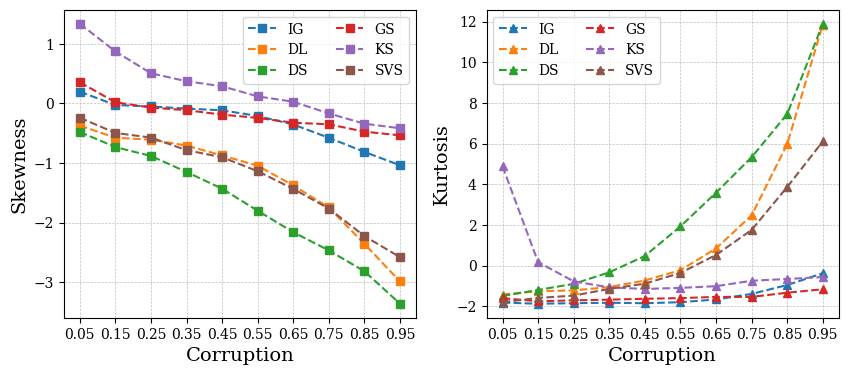

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(all_qfeatures, skewness_top[0], label='IG', marker='s', linestyle='dashed')
ax[0].plot(all_qfeatures, skewness_top[1], label='DL', marker='s', linestyle='dashed')
ax[0].plot(all_qfeatures, skewness_top[2], label='DS', marker='s', linestyle='dashed')
ax[0].plot(all_qfeatures, skewness_top[3], label='GS', marker='s', linestyle='dashed')
ax[0].plot(all_qfeatures, skewness_top[4], label='KS', marker='s', linestyle='dashed')
ax[0].plot(all_qfeatures, skewness_top[5], label='SVS', marker='s', linestyle='dashed')
ax[0].grid(lw=0.5, alpha=0.8, ls='dashed')
ax[0].set_xticks(all_qfeatures)
ax[0].legend(ncol=2)
ax[0].set_xlabel("Corruption", fontsize=14)
ax[0].set_ylabel("Skewness", fontsize=14)


ax[1].plot(all_qfeatures, kurtosis_top[0], label='IG', marker='^', linestyle='dashed')
ax[1].plot(all_qfeatures, kurtosis_top[1], label='DL', marker='^', linestyle='dashed')
ax[1].plot(all_qfeatures, kurtosis_top[2], label='DS', marker='^', linestyle='dashed')
ax[1].plot(all_qfeatures, kurtosis_top[3], label='GS', marker='^', linestyle='dashed')
ax[1].plot(all_qfeatures, kurtosis_top[4], label='KS', marker='^', linestyle='dashed')
ax[1].plot(all_qfeatures, kurtosis_top[5], label='SVS', marker='^', linestyle='dashed')
ax[1].grid(lw=0.5, alpha=0.8, ls='dashed')
ax[1].set_xticks(all_qfeatures)
ax[1].legend(ncol=2)
ax[1].set_xlabel("Corruption", fontsize=14)
ax[1].set_ylabel("Kurtosis", fontsize=14)
plt.savefig(os.path.join("interpretability_results/visualization_results", "skew_kurt.png"), dpi=200, bbox_inches='tight')

## Normalized skewness and kurtosis

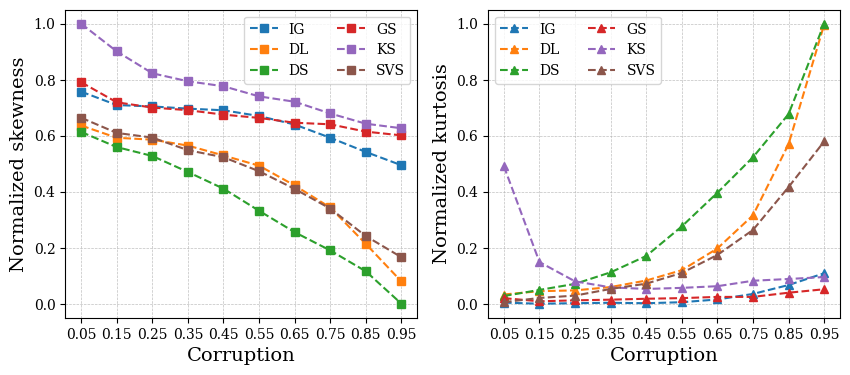

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(all_qfeatures, skewness_top_[0], label='IG', marker='s', linestyle='dashed')
ax[0].plot(all_qfeatures, skewness_top_[1], label='DL', marker='s', linestyle='dashed')
ax[0].plot(all_qfeatures, skewness_top_[2], label='DS', marker='s', linestyle='dashed')
ax[0].plot(all_qfeatures, skewness_top_[3], label='GS', marker='s', linestyle='dashed')
ax[0].plot(all_qfeatures, skewness_top_[4], label='KS', marker='s', linestyle='dashed')
ax[0].plot(all_qfeatures, skewness_top_[5], label='SVS', marker='s', linestyle='dashed')
ax[0].grid(lw=0.5, alpha=0.8, ls='dashed')
ax[0].set_xticks(all_qfeatures)
ax[0].legend(ncol=2)
ax[0].set_xlabel("Corruption", fontsize=14)
ax[0].set_ylabel("Normalized skewness", fontsize=14)


ax[1].plot(all_qfeatures, kurtosis_top_[0], label='IG', marker='^', linestyle='dashed')
ax[1].plot(all_qfeatures, kurtosis_top_[1], label='DL', marker='^', linestyle='dashed')
ax[1].plot(all_qfeatures, kurtosis_top_[2], label='DS', marker='^', linestyle='dashed')
ax[1].plot(all_qfeatures, kurtosis_top_[3], label='GS', marker='^', linestyle='dashed')
ax[1].plot(all_qfeatures, kurtosis_top_[4], label='KS', marker='^', linestyle='dashed')
ax[1].plot(all_qfeatures, kurtosis_top_[5], label='SVS', marker='^', linestyle='dashed')
ax[1].grid(lw=0.5, alpha=0.8, ls='dashed')
ax[1].set_xticks(all_qfeatures)
ax[1].legend(ncol=2)
ax[1].set_xlabel("Corruption", fontsize=14)
ax[1].set_ylabel("Normalized kurtosis", fontsize=14)
plt.savefig(os.path.join("interpretability_results/visualization_results", "skew_kurt_norm.png"), dpi=200, bbox_inches='tight')

## Calculate AUC of skewness and kurtosis
for metric:
1. 1-AUCskew
2. AUCkurt

In [36]:
aucskew = []
aucskew.append(1-calculate_auc(all_qfeatures, skewness_top_[0]))
aucskew.append(1-calculate_auc(all_qfeatures, skewness_top_[1]))
aucskew.append(1-calculate_auc(all_qfeatures, skewness_top_[2]))
aucskew.append(1-calculate_auc(all_qfeatures, skewness_top_[3]))
aucskew.append(1-calculate_auc(all_qfeatures, skewness_top_[4]))
aucskew.append(1-calculate_auc(all_qfeatures, skewness_top_[5]))
auckurt = []
auckurt.append(calculate_auc(all_qfeatures, kurtosis_top_[0]))
auckurt.append(calculate_auc(all_qfeatures, kurtosis_top_[1]))
auckurt.append(calculate_auc(all_qfeatures, kurtosis_top_[2]))
auckurt.append(calculate_auc(all_qfeatures, kurtosis_top_[3]))
auckurt.append(calculate_auc(all_qfeatures, kurtosis_top_[4]))
auckurt.append(calculate_auc(all_qfeatures, kurtosis_top_[5]))
print(aucskew)
print(auckurt)

[0.4127056002572913, 0.5896834828306755, 0.6831484018822698, 0.395211538697511, 0.3107154507476009, 0.5845525626945475]
[0.018587004512417737, 0.19523291867694936, 0.2789686295604638, 0.019678904960043486, 0.09225002265695725, 0.14308862377713213]


## Scaled metrics to [0, 1]

In [37]:
scaled_aucskew = normalization(aucskew)
scaled_auckurt = normalization(auckurt)
print(scaled_aucskew)
print(scaled_auckurt)

[0.27384835 0.74904229 1.         0.22687597 0.         0.73526553]
[0.         0.6784116  1.         0.00419346 0.28290406 0.47815056]


## diff $AUC \tilde{S} = AUC_{top} - AUC_{bot}$

In [33]:
required_columns = [
    "metric_score",
    "mean_ratio_pts_removed"
]
methods = [
    'integrated_gradients',
    'deeplift',
    'deepliftshap',
    'gradshap',
    'kernelshap',
    'shapleyvalue'
]

diffaucs = {}

for method in methods:
    results_path = "interpretability_results/"
    df_top = pd.read_csv(
        os.path.join(results_path, f"summary_relevance_{method}__top.csv"),
        index_col=0
    )
    df_top = df_top.sort_index()
    df_top = df_top[required_columns].copy().rename(columns={'metric_score': 'top'})

    df_bot = pd.read_csv(
        os.path.join(results_path, f"summary_relevance_{method}__bottom.csv"),
        index_col=0
    )
    df_bot = df_bot.sort_index()
    df_bot = df_bot[required_columns].copy().rename(columns={'metric_score': 'bottom'})
    
    diffaucs[method] = calculate_auc(df_top['mean_ratio_pts_removed'], df_top['top']) - calculate_auc(df_bot['mean_ratio_pts_removed'], df_bot['bottom'])

print(diffaucs)

{'integrated_gradients': 0.1667031819912195, 'deeplift': 0.24366084657872983, 'deepliftshap': 0.28254736570659894, 'gradshap': 0.17461195413381833, 'kernelshap': 0.007046448560069668, 'shapleyvalue': 0.23918010540118673}


In [75]:
scaled_diffaucs = normalization(list(diffaucs.values()))
print(list(diffaucs.values()))
print(scaled_diffaucs)

[0.1667031819912195, 0.24366084657872983, 0.28254736570659894, 0.17461195413381833, 0.007046448560069668, 0.23918010540118673]
[0.57951434 0.85885158 1.         0.60822123 0.         0.8425876 ]


# calculate Xpower

In [76]:
print(scaled_diffaucs)
print(scaled_aucskew)
print(scaled_auckurt)

[0.57951434 0.85885158 1.         0.60822123 0.         0.8425876 ]
[0.27384835 0.74904229 1.         0.22687597 0.         0.73526553]
[0.         0.6784116  1.         0.00419346 0.28290406 0.47815056]


In [77]:
xpower = scaled_diffaucs * 0.5 + scaled_aucskew * 0.4 + scaled_auckurt * 0.1
xpower

array([0.39929651, 0.79688387, 1.        , 0.39528035, 0.02829041,
       0.76321507])

In [78]:
print(normalization(xpower))

[0.3818076  0.79097033 1.         0.37767451 0.         0.7563213 ]


## signal visulization

In [58]:
nounid = np.load('nounid.npy')
signal = np.load('signal.npy')
target = np.load('target.npy')

In [59]:
sample = np.random.choice(nounid, 1)[0]
sample

'sample_834'

In [60]:
signal_sample = signal[np.where(nounid == sample)[0]]
signal_sample.shape

(1, 4, 500)

In [61]:
df_rel = pd.read_csv("interpretability_results/interpretability_raw/intepretability_deepliftshap.csv")
bool_columns = [f"{sample}_" in x for x in df_rel.columns]
interp = df_rel.loc[:, bool_columns].values
interp.shape

(500, 4)

In [65]:
sum_rel_neg = interp[interp < 0].sum()
sum_rel_pos = interp[interp >= 0].sum()

sp_interp_all = interp[interp >= 0]

k_feature = 0.1
quantile = 1 - k_feature
thres_p = np.quantile(sp_interp_all, quantile)

df_signal = pd.DataFrame(signal_sample[0].transpose(1,0))
modified_signal = pd.DataFrame(np.nan, index=df_signal.index, columns=df_signal.columns)
modified_signal

,0,1,2,3
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN
...,...,...,...,...
495,NaN,NaN,NaN,NaN
496,NaN,NaN,NaN,NaN
497,NaN,NaN,NaN,NaN
498,NaN,NaN,NaN,NaN


In [66]:
import more_itertools as mit

epsilon = 1e-12
frac_pts_rel = np.zeros(interp.shape[1])
mean_windows_rel = np.zeros(
    interp.shape[1]
)  # mean len continuous windows with rel>quantile
tic = np.zeros(interp.shape[1])

n_pts_removed = np.zeros(interp.shape[1])
ratio_pts_removed = np.zeros(interp.shape[1])

for coord in range(df_signal.shape[1]):

    s = df_signal.loc[:, coord]
    s_interp = pd.Series(interp[:, coord].copy())

    sp_interp = s_interp[s_interp >= 0]
    sp_tmp = sp_interp[sp_interp >= thres_p]

    grouped_index = mit.consecutive_groups(sp_tmp.index.values)
    window_len = np.array([len(list(x)) for x in grouped_index])
    mean_windows_rel[coord] = (
        np.nanmean(window_len) if len(window_len) > 0 else 0
    )
    mean_windows_rel[coord] = max(1, mean_windows_rel[coord])

    if sp_tmp.shape[0] == 0:
        frac_pts_rel[coord] = 0
        tic[coord] = 0
        n_pts_removed[coord] = 0
        ratio_pts_removed[coord] = 0
    else:
        # statistical quantities positive
        sp_interp_var = np.var(sp_interp)

        if sp_interp_var < 1e-8:
            frac_pts_rel[coord] = 0
        else:
            frac_pts_rel[coord] = sp_tmp.shape[0] / (
                sp_interp.shape[0] + epsilon
            )

        # if sp_tmp.shape[0] < 1:
        #     tic[coord] = 0
        # else:
        #     tic[coord] = integrate.simpson(sp_tmp) / (
        #         integrate.simpson(sp_interp) + epsilon
        #     )

        n_pts_removed[coord] = sp_tmp.shape[0]
        ratio_pts_removed[coord] = n_pts_removed[coord] / s.shape[0]

    modified_signal.loc[sp_tmp.index, coord] = np.random.normal(
        scale=1, size=sp_tmp.shape[0]
    )
modified_signal

,0,1,2,3
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN
...,...,...,...,...
495,NaN,NaN,NaN,NaN
496,NaN,NaN,NaN,NaN
497,NaN,NaN,NaN,NaN
498,NaN,NaN,NaN,NaN


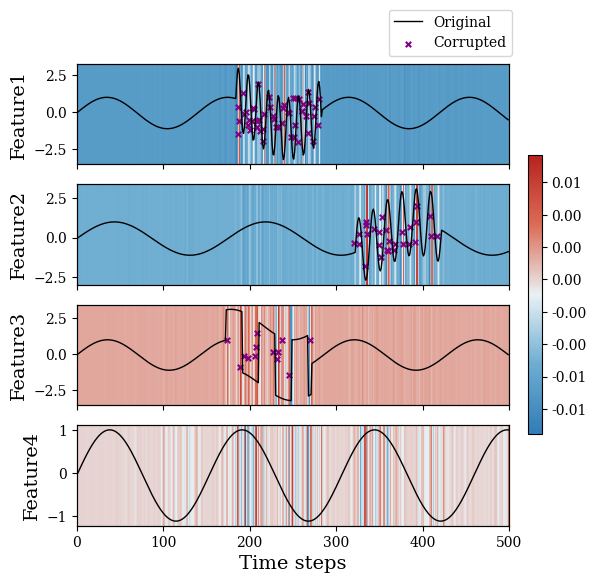

In [70]:
import matplotlib.cm as cm
plt.rc('font', family='serif')
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
colorlist = ['#317cb7', '#6dadd1', '#e9f1f4', '#dc6d57', '#b7221f']
newcmap = LinearSegmentedColormap.from_list('new_colormap', colorlist, N=256)

modified_signal_ = modified_signal.values
fig, ax = plt.subplots(nrows=signal_sample[0].shape[0],  figsize=(6, 6), sharex=True)
for idx in range(signal_sample[0].shape[0]):
    im = ax[idx].imshow(interp[:,idx].reshape(1,-1), cmap=newcmap, aspect='auto')
    ax[idx].set_yticks([])
    # ax[idx].yaxis.set_tick_params(labelsize=14)
    ax_ = ax[idx].twinx()

    ax_.plot(signal_sample[0][idx,:], color='black', linewidth=1, label='Original')
    ax_.scatter(range(0, 500), modified_signal_[:, idx], color='purple', s=15, marker='x', label='Corrupted')
    ax_.set_ylabel(f"Feature{idx+1}", fontsize = 14)
    handles, labels = ax_.get_legend_handles_labels()
    # ax[idx].set_title("Feature {}".format(idx+1), fontsize = 20)

    ax[idx].set_xlim(0, 500)

    ax_.yaxis.tick_left()
    ax_.yaxis.set_label_position('left')
    
ax[-1].set_xlabel("Time steps", fontsize = 14)
fig.legend(handles, labels, bbox_to_anchor=(0.85, 0.97), borderaxespad=0., fontsize=10)
fig.colorbar(im, ax=[ax[0], ax[1], ax[2], ax[3]], fraction=0.03, pad=0.04, format='%.2f')
plt.savefig("interpretability_results/visualization_results/signal_rel_10percent.png", dpi=300, bbox_inches='tight')